In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import sys
import _experiment 
importlib.reload(sys.modules['_experiment'])
from _experiment import Experiment

In [2]:
# USER INPUT: set personal configurations here

# Configurations for postgres server: change values only, do not change keys
postgres_settings = {
    "user": "temp",
    "password": "1234",
    "host": "localhost",
    "port": "5432",
    "database": "mydb"
}

# Configurations for MongoDB: change values only, do not change keys
mongodb_settings = {
    "host": "mongodb://localhost:27017/",
    "database": "bigdata"
}

# Your name for experiment logging
person = 'rob'

In [3]:
exp1 = Experiment()

Created instance of Experiment class to measure database response times


In [4]:
exp1.connect(postgres_settings, mongodb_settings)

Connection to MongoDB successful
Connection to Postgres successful


In [5]:
exp1.prepare_databases(os.getcwd())

In [6]:
exp1.execute('rob')

--------------------------------------------------------------------------------------
Start with experiment on arrest_db data set in relational database
	 All postgres tables dropped
	 	 Imported data size 50000 to postgres in 670.0429916381836 ms
	 	 Executed query 1 10 times with avg. response time 22.50058650970459 ms
	 	 Executed query 2 10 times with avg. response time 58.90326499938965 ms
	 	 Executed query 3 10 times with avg. response time 15.378546714782715 ms
	 	 Executed query 4 10 times with avg. response time 188.2782220840454 ms
	 	 Executed query 5 10 times with avg. response time 78.19502353668213 ms
	 	 Executed query 6 10 times with avg. response time 144.87638473510742 ms
	 	 Executed query 7 10 times with avg. response time 185.7344627380371 ms
	 	 Executed query 8 10 times with avg. response time 121.8606948852539 ms
	 	 Executed query 9 10 times with avg. response time 174.9314546585083 ms
	 	 Executed query 10 10 times with avg. response time 6.037092208862305 m

	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 Executed query 4 10 times with avg. response time 10012.068176269531 ms
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 Executed query 5 10 times with avg. response time 10013.192105293274 ms
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 Executed query 6 10 times with avg. response time 10013.008403778076 ms
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit e

	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 Executed query 4 10 times with avg. response time 10012.003302574158 ms
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 Executed query 5 10 times with avg. response time 10012.683629989624 ms
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 Executed query 6 10 times with avg. response time 10012.731218338013 ms
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit exceeded
	 	 	 Time limit e

	 	 Executed query 2 10 times with avg. response time 4.223728179931641 ms
	 	 Executed query 3 10 times with avg. response time 16.18320941925049 ms
	 	 Executed query 4 10 times with avg. response time 4.130148887634277 ms
	 	 Executed query 5 10 times with avg. response time 4.655337333679199 ms
	 	 Executed query 6 10 times with avg. response time 5.21543025970459 ms
	 	 Executed query 7 10 times with avg. response time 4.073429107666016 ms
	 	 Executed query 8 10 times with avg. response time 3.604888916015625 ms
	 	 Executed query 9 10 times with avg. response time 3.5740137100219727 ms
	 	 Executed query 10 10 times with avg. response time 16.146469116210938 ms
	 	 Executed query 11 10 times with avg. response time 0.6643772125244141 ms
	 All mongoDB tables dropped
	 	 Imported data size 13000 to mongoDB in 1142.6701545715332 ms
	 	 Executed query 1 10 times with avg. response time 23.123908042907715 ms
	 	 Executed query 2 10 times with avg. response time 7.63392448425293 ms
	 

In [8]:
df=exp1.get_results()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2220 entries, 0 to 2219
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   person         2220 non-null   object 
 1   data_set       2220 non-null   object 
 2   data_store     2220 non-null   object 
 3   data_size      2220 non-null   object 
 4   query          2220 non-null   object 
 5   trial          2220 non-null   object 
 6   response_time  2220 non-null   float64
dtypes: float64(1), object(6)
memory usage: 121.5+ KB


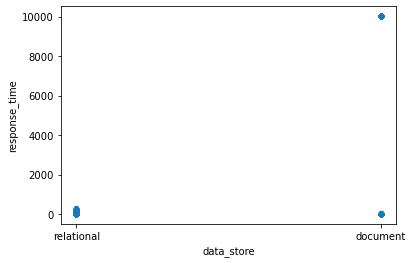

In [10]:
df[df['query']=='4'].plot(kind='scatter',x='data_store',y='response_time')
plt.show()

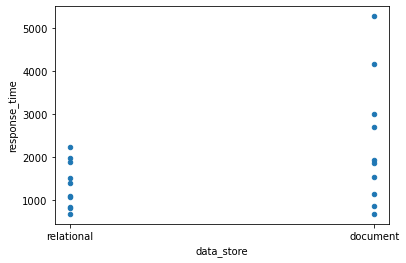

In [11]:
df[df['query']=='import'].plot(kind='scatter',x='data_store',y='response_time')
plt.show()

In [12]:
exp1.export_results()